<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4 : West Nile Virus Prediction
### Notebook 4 of 4: Spray Analysis

## Contents:
- [Import libraries](#Import-libraries)
- [Import data from Pickle](#Import-data-from-Pickle)
- [Define functions](#Define-functions)
- [Spray Analysis](#Spray-Analysis)
- [Recommendation](#Recommendation)
- [Conclusion](#Conclusion)

# Import libraries
*Back to [Contents](#Contents:)*

In [1]:
# Imports:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.mode.chained_assignment = None 

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.dummy import DummyClassifier

from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler 

from sklearn.cluster import KMeans

import lightgbm as lgb

import pickle

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

get_ipython().run_line_magic('matplotlib', 'inline')

pd.options.display.max_columns = None
pd.options.display.max_rows = None

import geopandas as gpd

import datetime

In [2]:
#steps to install geopandas

#!pip install pipwin
#!pipwin install gdal
#!pipwin install fiona
#!pip install geopandas
#!pipwin install rasterio
#!pip install contextily

In [3]:
#!pip install imblearn

In [4]:
#!pip install lightgbm

# Import data from Pickle
*Back to [Contents](#Contents:)*

In [5]:
# read pickle_dict, which stores everything
pickle_dict1 = pickle.load(open('./assets/data1.pkl', 'rb'))

df_train = pickle_dict1['df_train']
df_test = pickle_dict1['df_test']
df_spray = pickle_dict1['df_spray']
df_weather_1 = pickle_dict1['df_weather_1']
df_weather_2 = pickle_dict1['df_weather_2']

## Define functions
*Back to [Contents](#Contents:)*

In [6]:
# the function will 
# 1. plot neighborhoods map of chicago
# 2. plot 2 weather stations on the map
# 3. based on the input parameters,
#   a. convert the input dataframe into geopandas dataframe
#   b. plot the dataframe on the chicago map. 
#   c. if the dataframe contain column 'NumMosquitos', the function will adjust the markersize according to 'NumMosquitos'

def plot_geodata(dict_df,   # dictionary containing dataframe and its name
                ):
    
    colors = ['black','orange','red','yellow']
    markersizes = [3, 1, 14, 5]
    zorders = [4, 1, 3, 2]
    
    fig_, ax_ = plt.subplots(figsize=(20,20))
    
    # plot neighborhoods map of chicago
    geojson_file = './assets/Boundaries_Community_Areas.geojson'
    neighborhoods = gpd.read_file(geojson_file)
    neighborhoods.plot(ax=ax_)
    
    # plot station
    # initialize list of lists
    list_station = [['1',  41.995,-87.933], ['2', 41.786,-87.752]]
    df_station = pd.DataFrame(list_station, columns=['Station', 'Latitude', 'Longitude'])
    gdf = gpd.GeoDataFrame(df_station, geometry=gpd.points_from_xy(df_station.Longitude, df_station.Latitude))
    gdf.plot(ax=ax_, color='yellow', markersize=20, zorder=5, label="Weather station")
    
    # plot input dataframes
    i=0
    for label_df, df in dict_df.items():
        color_ = colors[i]
        
        # if the dataframe has column 'NumMosquitos', the markersize will be adjusted according to this column
        if 'NumMosquitos' in df.columns:
            markersize_ = df['NumMosquitos']*3
        else:
            markersize_ = markersizes[i]
        zorder_ = zorders[i]
        label_ = label_df

        gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
        gdf.plot(ax=ax_, color=color_, markersize=markersize_, zorder=zorder_, label=label_)
        
        i += 1
        
    ax_.legend(loc='lower left', fontsize=12, markerscale=3)
    plt.show()
    return 

### Set up a limit table to be used in below function to zoom in to the plot areas

In [7]:
# limit_table = {'spraydate': ['2011-09-07', '2013-07-17', '2013-07-25', 
#                              '2013-08-08', '2013-08-15', '2013-08-16',
#                              '2013-08-22', '2013-08-29', '2013-09-05'],
#                'xlim_left': [-87.85, -87.85, -87.85, -87.85, -87.25,
#                              -87.85, -87.85, -87.85, -87.85],
#                'xlim_right': [-87.75, -87.75, -87.75, -87.75, -87.75,
#                              -87.75, -87.75, -87.75, -87.75],
#                'ylim_bottom': [41.95, 41.95, 41.95, 41.95, 41.95,
#                              41.95, 41.95, 41.95, 41.95],
#                'ylim_top': [42, 42, 42, 42, 42,
#                              42, 42, 42, 42]
#                              }
# limit_table_df = pd.DataFrame(limit_table)
# limit_table_df['spraydate'] = pd.to_datetime(limit_table_df['spraydate'])

# limit_table_df

In [8]:
# add an extra 0.018 to limits to see surrounding areas
limit_table = pd.merge(df_spray.groupby('Date').min()-0.018,
                       df_spray.groupby('Date').max()+0.018, on='Date')
limit_table = limit_table.reset_index()
limit_table

,Date,Latitude_x,Longitude_x,Latitude_y,Longitude_y
0,2011-09-07,41.95,-87.85,42.02,-87.77
1,2013-07-17,41.70,-87.89,42.03,-87.61
2,2013-07-25,41.92,-87.76,41.99,-87.69
3,2013-08-08,41.90,-87.73,41.96,-87.66
4,2013-08-15,41.87,-87.84,41.98,-87.73
5,2013-08-16,41.89,-87.80,41.98,-87.73
6,2013-08-22,41.70,-87.75,41.91,-87.57
7,2013-08-29,41.74,-87.76,42.02,-87.64
8,2013-09-05,41.96,-87.86,42.04,-87.77


In [9]:
# the function is similar to the above plot_geodata EXCEPT
# it zooms in to the area of the spray!

# 1. plot neighborhoods map of chicago
# 2. plot 2 weather stations on the map
# 3. based on the input parameters,
#   a. convert the input dataframe into geopandas dataframe
#   b. plot the dataframe on the chicago map. 
#   c. if the dataframe contain column 'NumMosquitos', the function will adjust the markersize according to 'NumMosquitos'

def plot_spray(dict_df,   # dictionary containing dataframe and its name
               spray_date # if want to visualize the entire plot
                ):
    
    colors = ['black','orange','red','yellow']
    markersizes = [3, 1, 14, 5]
    zorders = [4, 1, 3, 2]
    
    fig_, ax_ = plt.subplots(figsize=(15,15))
    
    # returns the index on the table based on the spraydate
    table_index = limit_table[limit_table['Date']==spray_date].index[0]
    
    # set the limits of the plot to visualise the spray area better
    ax_.set_xlim([limit_table.iloc[table_index, 2], limit_table.iloc[table_index, 4]])
    ax_.set_ylim([limit_table.iloc[table_index, 1], limit_table.iloc[table_index, 3]])
        
    # plot neighborhoods map of chicago
    geojson_file = './assets/Boundaries_Community_Areas.geojson'
    neighborhoods = gpd.read_file(geojson_file)
    neighborhoods.plot(ax=ax_)
    
    # plot station
    # initialize list of lists
    list_station = [['1',  41.995,-87.933], ['2', 41.786,-87.752]]
    df_station = pd.DataFrame(list_station, columns=['Station', 'Latitude', 'Longitude'])
    gdf = gpd.GeoDataFrame(df_station, geometry=gpd.points_from_xy(df_station.Longitude, df_station.Latitude))
    gdf.plot(ax=ax_, color='yellow', markersize=20, zorder=5, label="Weather station")
    
    # plot input dataframes
    i=0
    for label_df, df in dict_df.items():
        color_ = colors[i]
        
        # if the dataframe has column 'NumMosquitos', the markersize will be adjusted according to this column
        if 'NumMosquitos' in df.columns:
            markersize_ = df['NumMosquitos']*3
        else:
            markersize_ = markersizes[i]
        zorder_ = zorders[i]
        label_ = label_df

        gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
        gdf.plot(ax=ax_, color=color_, markersize=markersize_, zorder=zorder_, label=label_)
        i += 1
        
    ax_.legend(loc='lower left', fontsize=12, markerscale=3)
    plt.show()
    return 

# Spray Analysis

*Back to [Contents](#Contents:)*

In [10]:
df_spray['Date'].unique()

array(['2011-09-07T00:00:00.000000000', '2013-07-17T00:00:00.000000000',
       '2013-07-25T00:00:00.000000000', '2013-08-08T00:00:00.000000000',
       '2013-08-15T00:00:00.000000000', '2013-08-16T00:00:00.000000000',
       '2013-08-22T00:00:00.000000000', '2013-08-29T00:00:00.000000000',
       '2013-09-05T00:00:00.000000000'], dtype='datetime64[ns]')

**There are a total of 9 spray dates, 1 in 2011 and the rest in 2013. We want to visualize if the spray area is different in 2011 and 2013.**

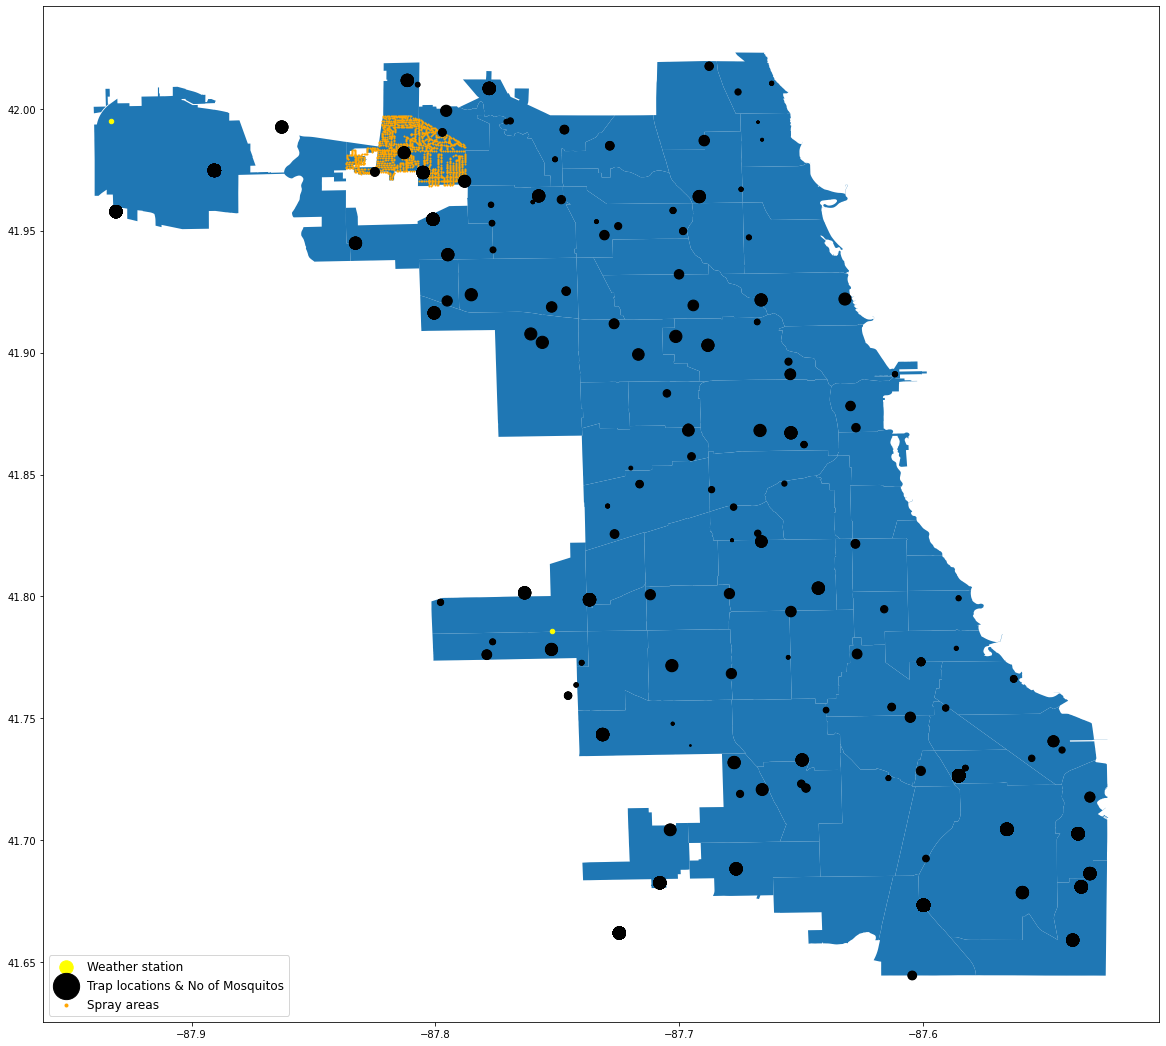

In [11]:
# spray areas in the year 2011
spray_date = pd.Timestamp(2011, 9, 7)

spray_2011 = {'Trap locations & No of Mosquitos':\
              df_train[df_train["Date"] <= spray_date],
              'Spray areas': df_spray[(df_spray["Date"] == spray_date)]
                 }
plot_geodata(spray_2011)

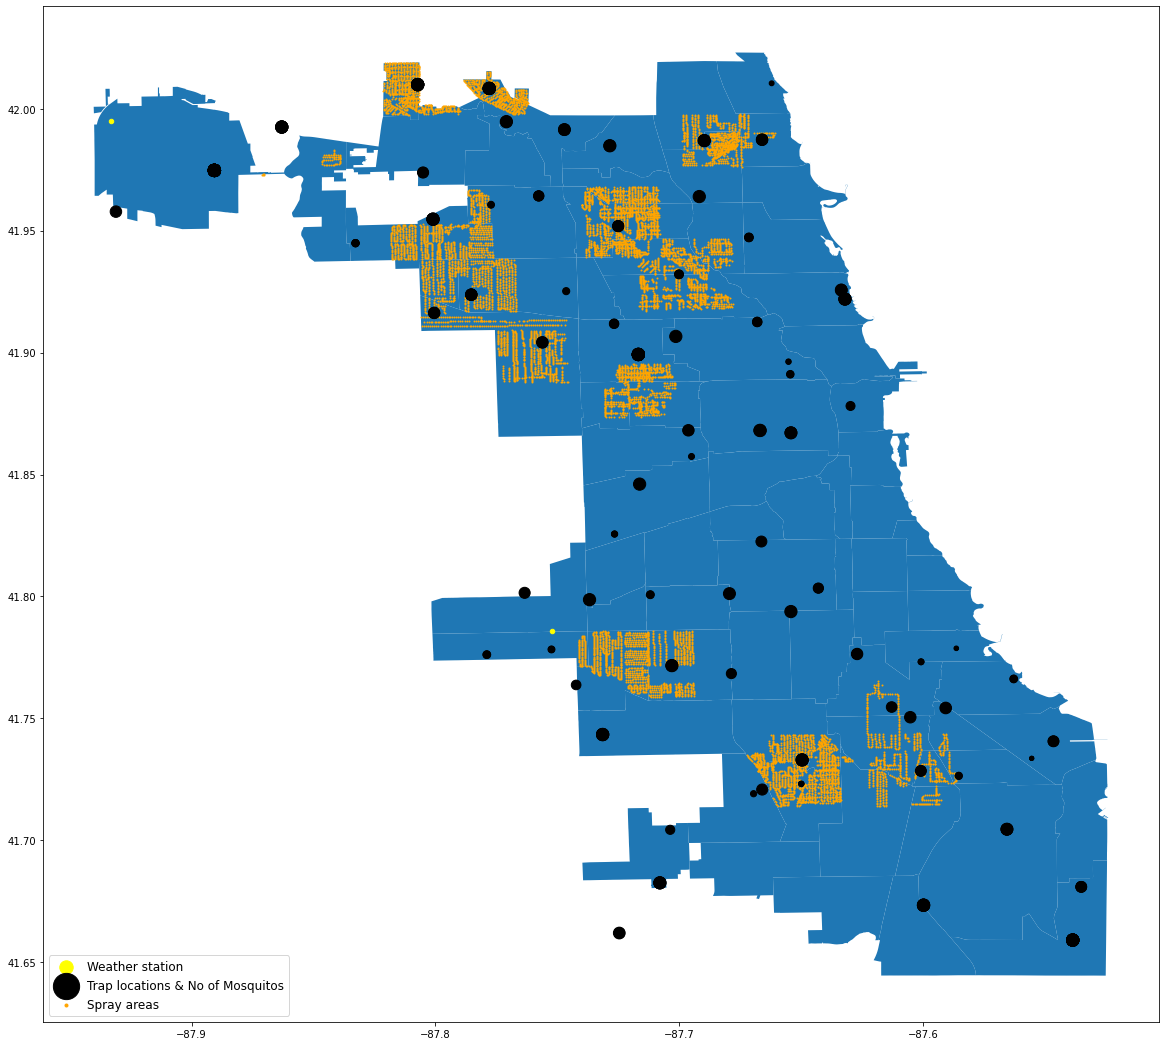

In [12]:
# spray areas in the year 2013
spray_date = pd.Timestamp(2013, 7, 17)

spray_2013 = {'Trap locations & No of Mosquitos':\
              df_train[df_train["Date"] >= spray_date],
              'Spray areas': df_spray[(df_spray["Date"] >= spray_date)]
                 }
plot_geodata(spray_2013)

**As we can see from the above 2 graphs, the spray areas are in different areas. To test the effectiveness of the spray, we look at the number of mosquitos two weeks before and two weeks after spraying.**

In [13]:
limit_table = pd.merge(df_spray.groupby('Date').min()-0.015, df_spray.groupby('Date').max()+0.015, on='Date')
limit_table = limit_table.reset_index()
limit_table

,Date,Latitude_x,Longitude_x,Latitude_y,Longitude_y
0,2011-09-07,41.95,-87.85,42.01,-87.77
1,2013-07-17,41.70,-87.89,42.03,-87.61
2,2013-07-25,41.92,-87.75,41.98,-87.69
3,2013-08-08,41.90,-87.73,41.96,-87.66
4,2013-08-15,41.87,-87.83,41.98,-87.73
5,2013-08-16,41.90,-87.80,41.98,-87.73
6,2013-08-22,41.70,-87.75,41.91,-87.57
7,2013-08-29,41.74,-87.76,42.01,-87.65
8,2013-09-05,41.96,-87.86,42.03,-87.77


## Spray effectiveness on 7 Sep 2011

Effect on number of mosquitos 2 weeks BEFORE 2011-09-07 00:00:00


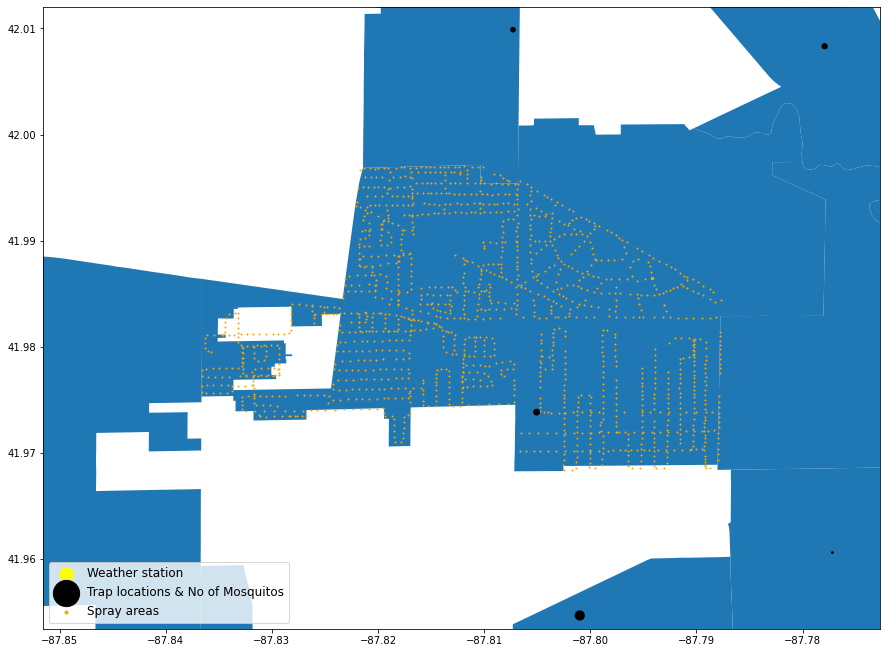

Effect on number of mosquitos 2 weeks AFTER 2011-09-07 00:00:00


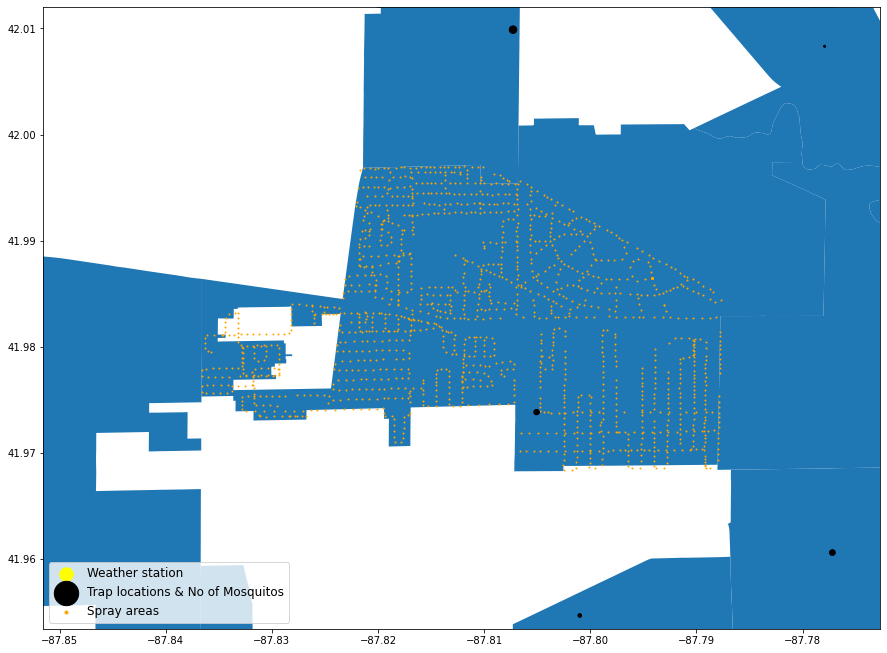

In [14]:
# mosquito numbers two weeks before spray
spray_date = pd.Timestamp(2011, 9, 7)

two_wks_before = {'Trap locations & No of Mosquitos':\
                  df_train[(df_train["Date"] >= spray_date - datetime.timedelta(weeks=2)) &\
                           (df_train["Date"] < spray_date)], 
                  'Spray areas': df_spray[(df_spray["Date"] == spray_date)]
                 }
   
print(f"Effect on number of mosquitos 2 weeks BEFORE {spray_date}")            
plot_spray(two_wks_before, spray_date)

# mosquito numbers two weeks after spray
two_wks_after = {'Trap locations & No of Mosquitos':\
                 df_train[(df_train["Date"] >= spray_date) &\
                          (df_train["Date"] < spray_date + datetime.timedelta(weeks=2))],
                 'Spray areas': df_spray[(df_spray["Date"] == spray_date)]
                }
print(f"Effect on number of mosquitos 2 weeks AFTER {spray_date}")
plot_spray(two_wks_after, spray_date)

## Spray effectiveness on 17 July 2011

Effect on number of mosquitos 2 weeks BEFORE 2013-07-17 00:00:00


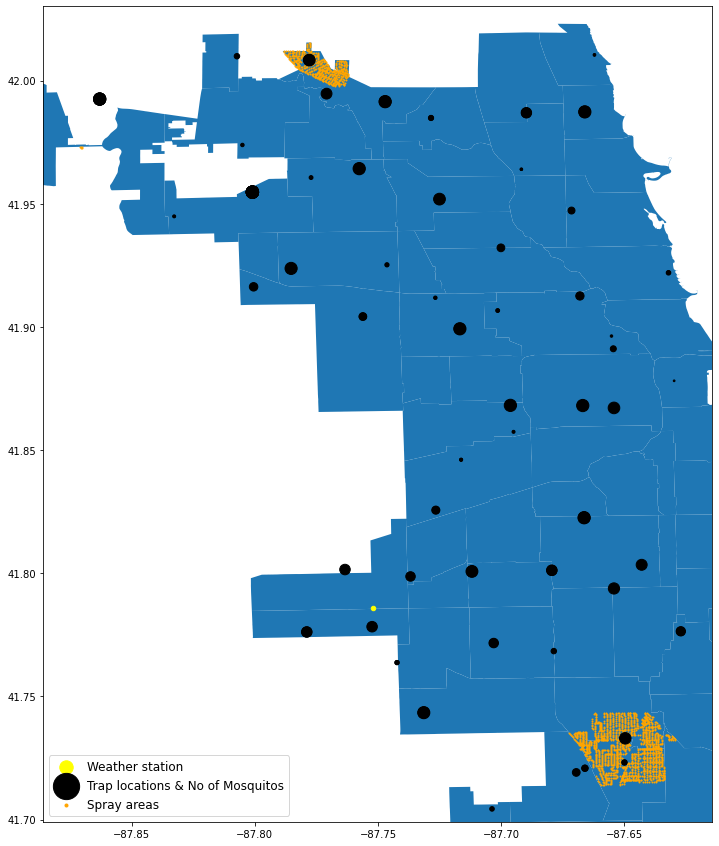

Effect on number of mosquitos 2 weeks AFTER 2013-07-17 00:00:00


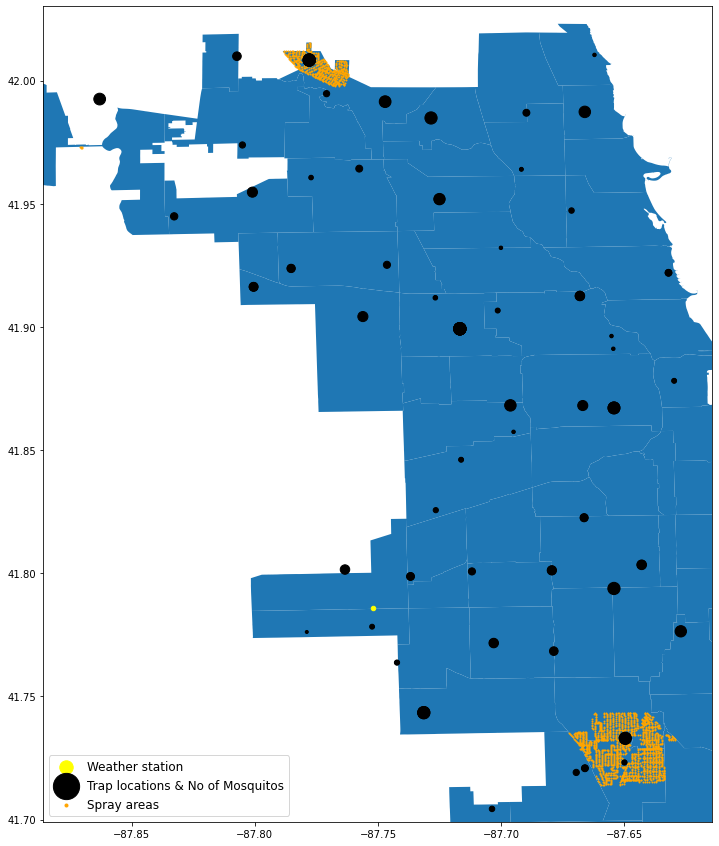

In [15]:
n=1
spray_date = pd.Timestamp(limit_table['Date'][n])

two_wks_before = {'Trap locations & No of Mosquitos':\
                  df_train[(df_train["Date"] >= spray_date - datetime.timedelta(weeks=2)) &\
                           (df_train["Date"] < spray_date)], 
                  'Spray areas': df_spray[(df_spray["Date"] == spray_date)]
                 }
   
print(f"Effect on number of mosquitos 2 weeks BEFORE {spray_date}")            
plot_spray(two_wks_before, spray_date)

# mosquito numbers two weeks after spray
two_wks_after = {'Trap locations & No of Mosquitos':\
                 df_train[(df_train["Date"] >= spray_date) &\
                          (df_train["Date"] < spray_date + datetime.timedelta(weeks=2))],
                 'Spray areas': df_spray[(df_spray["Date"] == spray_date)]
                }
print(f"Effect on number of mosquitos 2 weeks AFTER {spray_date}")
plot_spray(two_wks_after, spray_date)

## Spray effectiveness on 25 July 2013

Effect on number of mosquitos 2 weeks BEFORE 2013-07-25 00:00:00


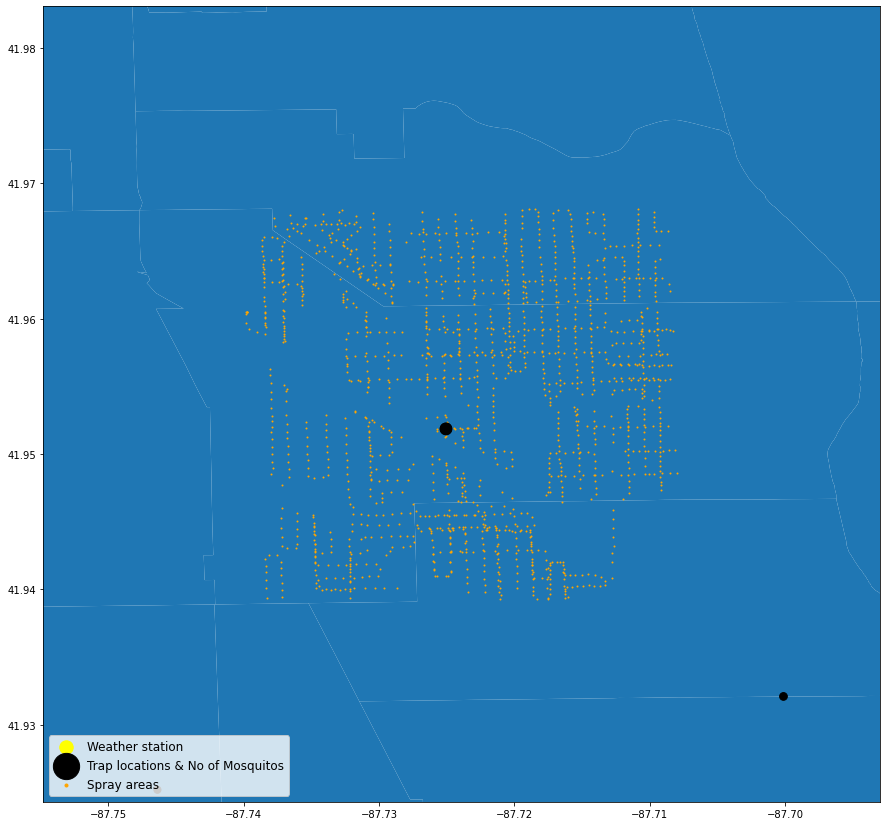

Effect on number of mosquitos 2 weeks AFTER 2013-07-25 00:00:00


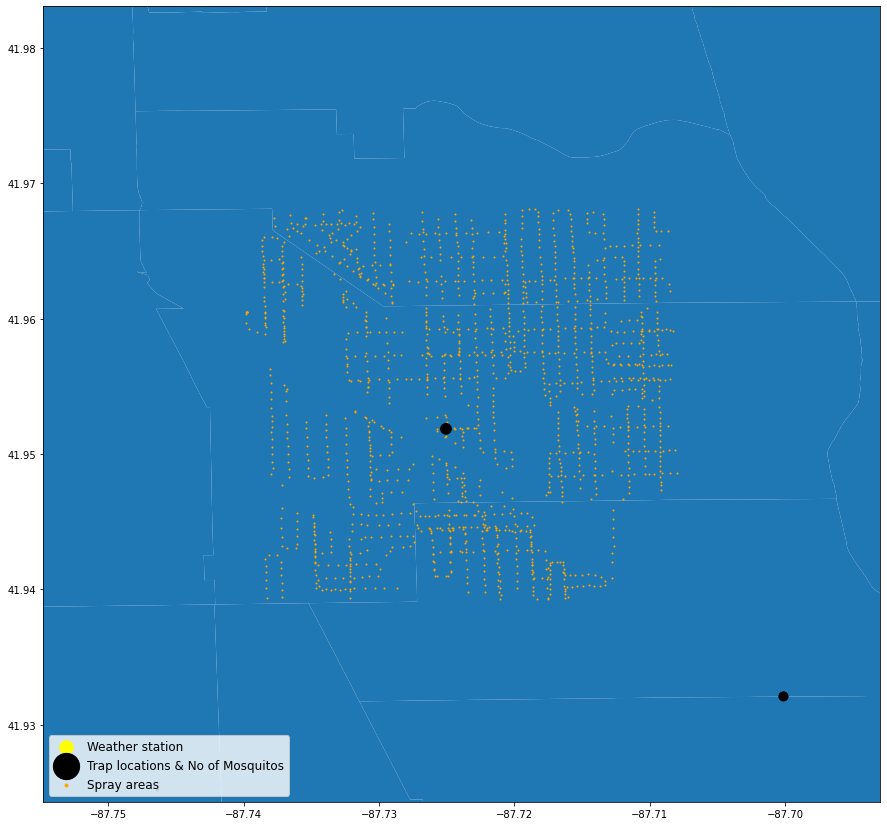

In [16]:
n=2
spray_date = pd.Timestamp(limit_table['Date'][n])

two_wks_before = {'Trap locations & No of Mosquitos':\
                  df_train[(df_train["Date"] >= spray_date - datetime.timedelta(weeks=2)) &\
                           (df_train["Date"] < spray_date)], 
                  'Spray areas': df_spray[(df_spray["Date"] == spray_date)]
                 }
   
print(f"Effect on number of mosquitos 2 weeks BEFORE {spray_date}")            
plot_spray(two_wks_before, spray_date)

# mosquito numbers two weeks after spray
two_wks_after = {'Trap locations & No of Mosquitos':\
                 df_train[(df_train["Date"] >= spray_date) &\
                          (df_train["Date"] < spray_date + datetime.timedelta(weeks=2))],
                 'Spray areas': df_spray[(df_spray["Date"] == spray_date)]
                }
print(f"Effect on number of mosquitos 2 weeks AFTER {spray_date}")
plot_spray(two_wks_after, spray_date)

## Spray effectiveness on 8 August 2013

Effect on number of mosquitos 2 weeks BEFORE 2013-08-08 00:00:00


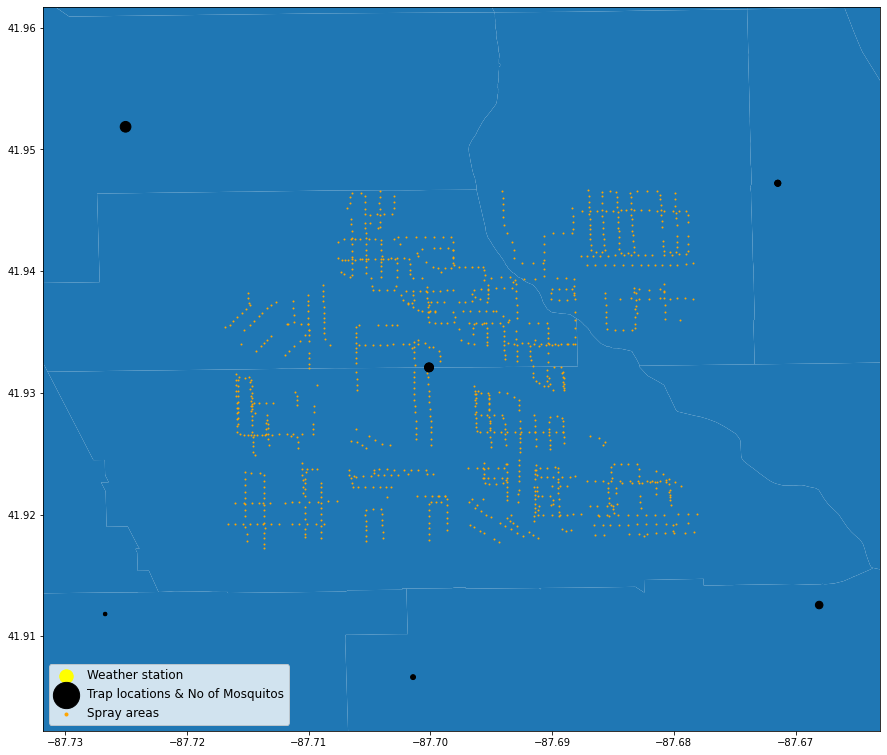

Effect on number of mosquitos 2 weeks AFTER 2013-08-08 00:00:00


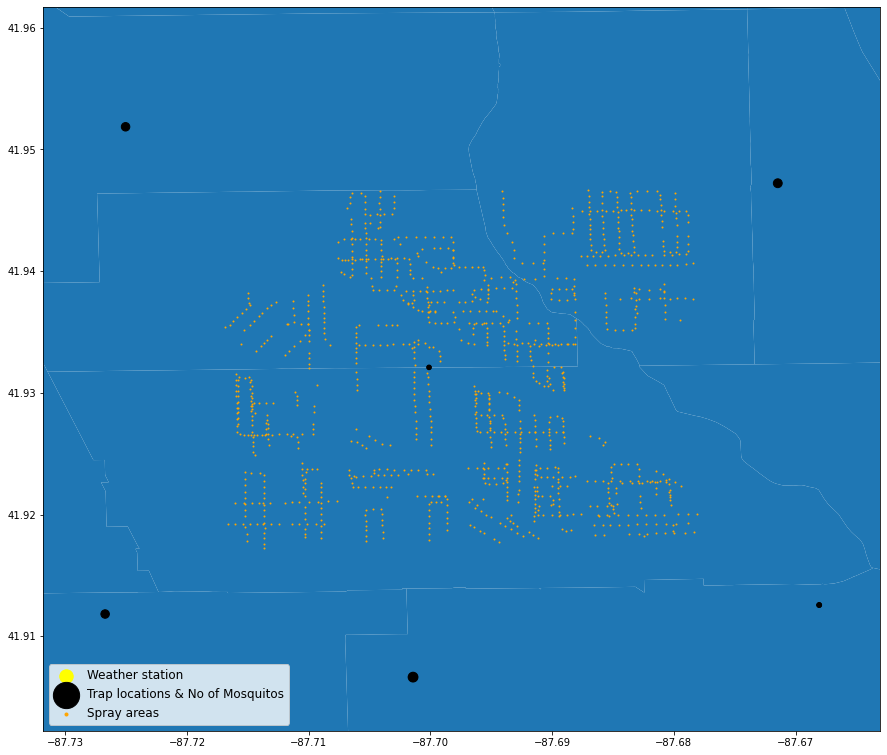

In [17]:
n=3
spray_date = pd.Timestamp(limit_table['Date'][n])

two_wks_before = {'Trap locations & No of Mosquitos':\
                  df_train[(df_train["Date"] >= spray_date - datetime.timedelta(weeks=2)) &\
                           (df_train["Date"] < spray_date)], 
                  'Spray areas': df_spray[(df_spray["Date"] == spray_date)]
                 }
   
print(f"Effect on number of mosquitos 2 weeks BEFORE {spray_date}")            
plot_spray(two_wks_before, spray_date)

# mosquito numbers two weeks after spray
two_wks_after = {'Trap locations & No of Mosquitos':\
                 df_train[(df_train["Date"] >= spray_date) &\
                          (df_train["Date"] < spray_date + datetime.timedelta(weeks=2))],
                 'Spray areas': df_spray[(df_spray["Date"] == spray_date)]
                }
print(f"Effect on number of mosquitos 2 weeks AFTER {spray_date}")
plot_spray(two_wks_after, spray_date)

## Spray effectiveness on 15 August 2013

Effect on number of mosquitos 2 weeks BEFORE 2013-08-15 00:00:00


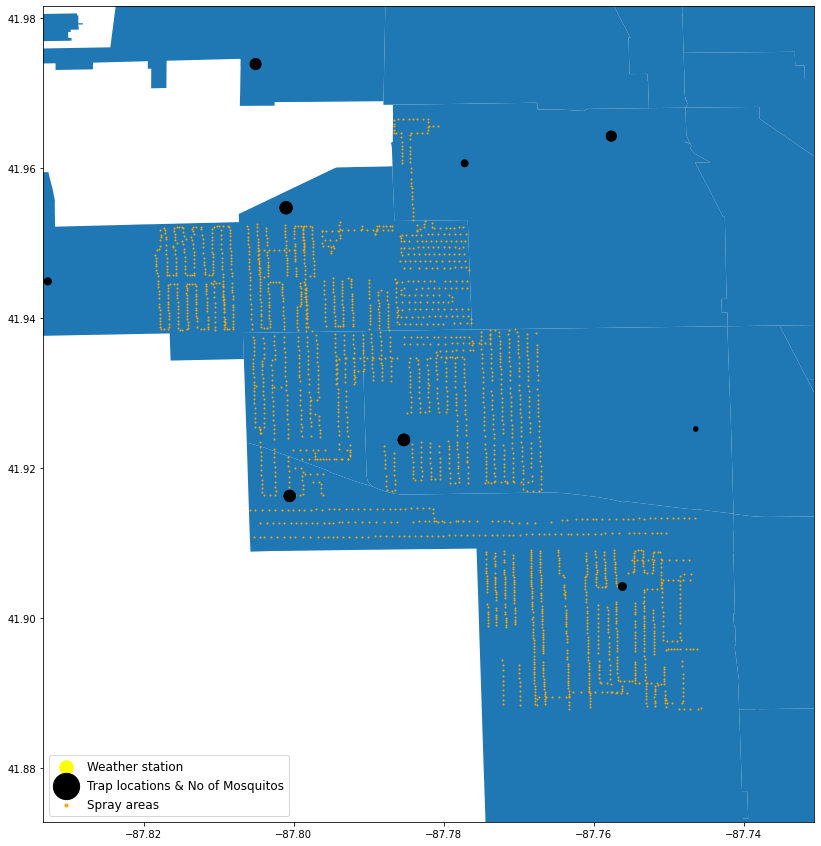

Effect on number of mosquitos 2 weeks AFTER 2013-08-15 00:00:00


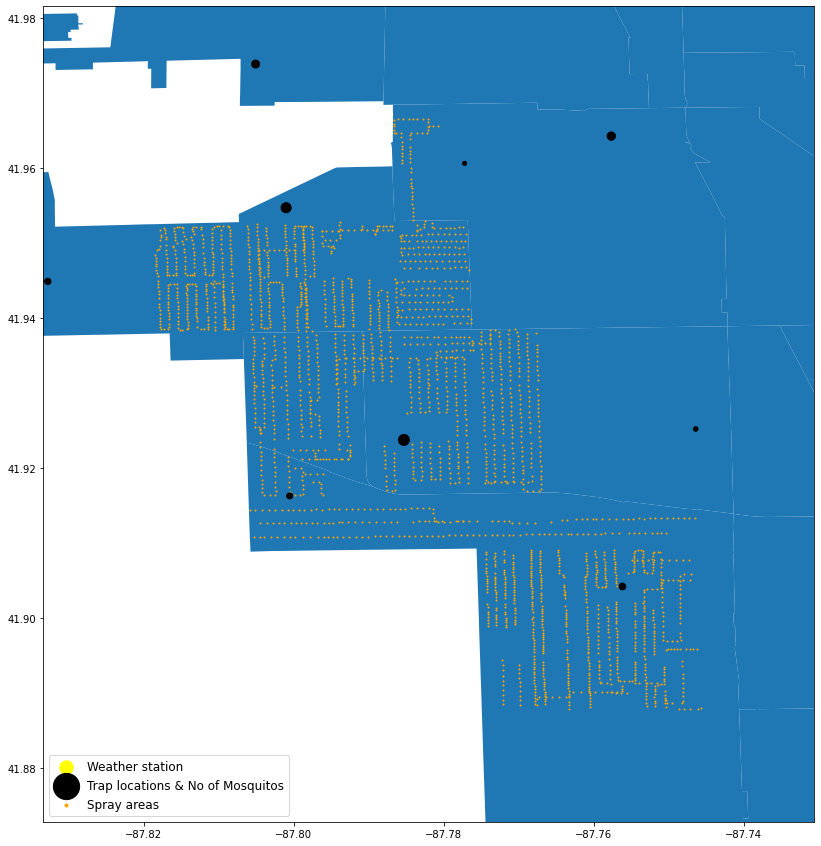

In [18]:
n=4
spray_date = pd.Timestamp(limit_table['Date'][n])

two_wks_before = {'Trap locations & No of Mosquitos':\
                  df_train[(df_train["Date"] >= spray_date - datetime.timedelta(weeks=2)) &\
                           (df_train["Date"] < spray_date)], 
                  'Spray areas': df_spray[(df_spray["Date"] == spray_date)]
                 }
   
print(f"Effect on number of mosquitos 2 weeks BEFORE {spray_date}")            
plot_spray(two_wks_before, spray_date)

# mosquito numbers two weeks after spray
two_wks_after = {'Trap locations & No of Mosquitos':\
                 df_train[(df_train["Date"] >= spray_date) &\
                          (df_train["Date"] < spray_date + datetime.timedelta(weeks=2))],
                 'Spray areas': df_spray[(df_spray["Date"] == spray_date)]
                }
print(f"Effect on number of mosquitos 2 weeks AFTER {spray_date}")
plot_spray(two_wks_after, spray_date)

## Spray effectiveness on 16 August 2013

Effect on number of mosquitos 2 weeks BEFORE 2013-08-16 00:00:00


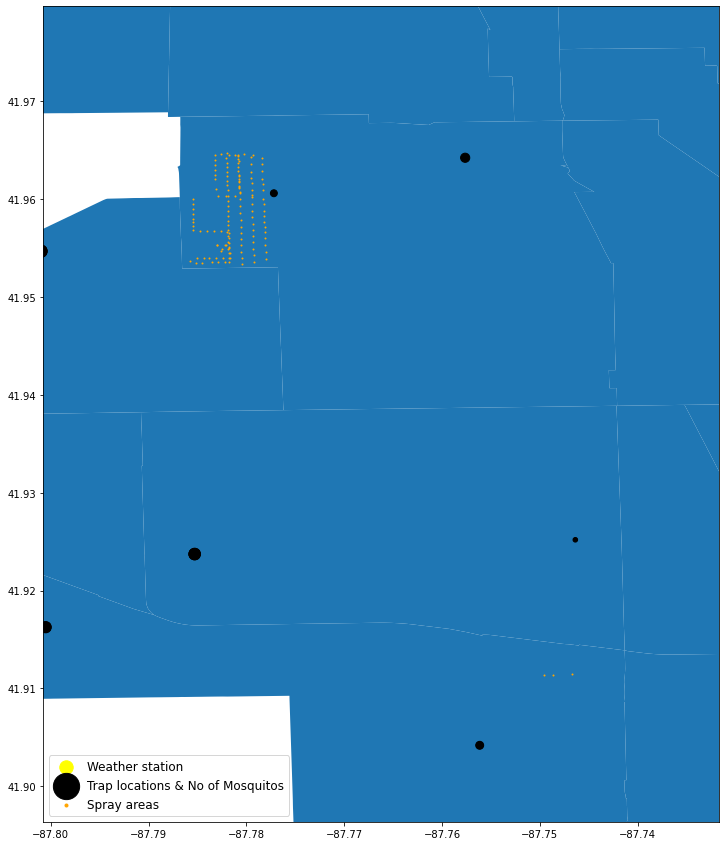

Effect on number of mosquitos 2 weeks AFTER 2013-08-16 00:00:00


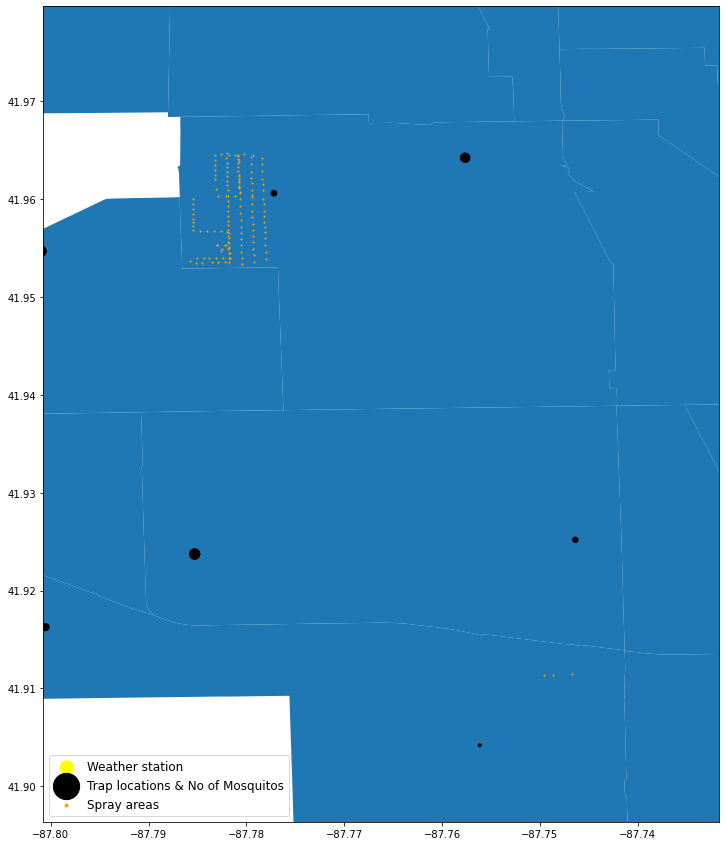

In [19]:
n=5
spray_date = pd.Timestamp(limit_table['Date'][n])

two_wks_before = {'Trap locations & No of Mosquitos':\
                  df_train[(df_train["Date"] >= spray_date - datetime.timedelta(weeks=2)) &\
                           (df_train["Date"] < spray_date)], 
                  'Spray areas': df_spray[(df_spray["Date"] == spray_date)]
                 }
   
print(f"Effect on number of mosquitos 2 weeks BEFORE {spray_date}")            
plot_spray(two_wks_before, spray_date)

# mosquito numbers two weeks after spray
two_wks_after = {'Trap locations & No of Mosquitos':\
                 df_train[(df_train["Date"] >= spray_date) &\
                          (df_train["Date"] < spray_date + datetime.timedelta(weeks=2))],
                 'Spray areas': df_spray[(df_spray["Date"] == spray_date)]
                }
print(f"Effect on number of mosquitos 2 weeks AFTER {spray_date}")
plot_spray(two_wks_after, spray_date)

## Spray effectiveness on 22 August 2013

Effect on number of mosquitos 2 weeks BEFORE 2013-08-22 00:00:00


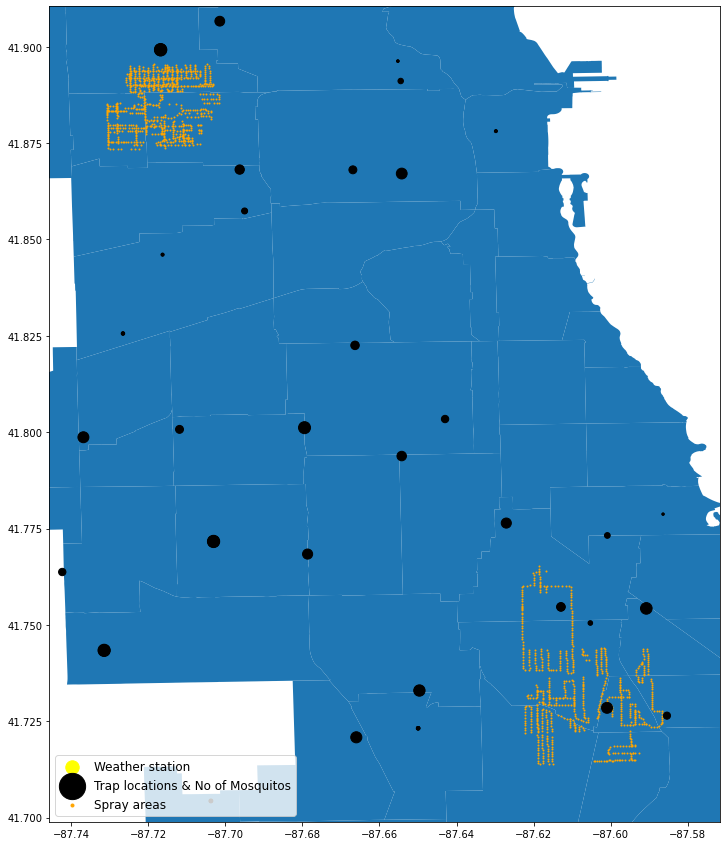

Effect on number of mosquitos 2 weeks AFTER 2013-08-22 00:00:00


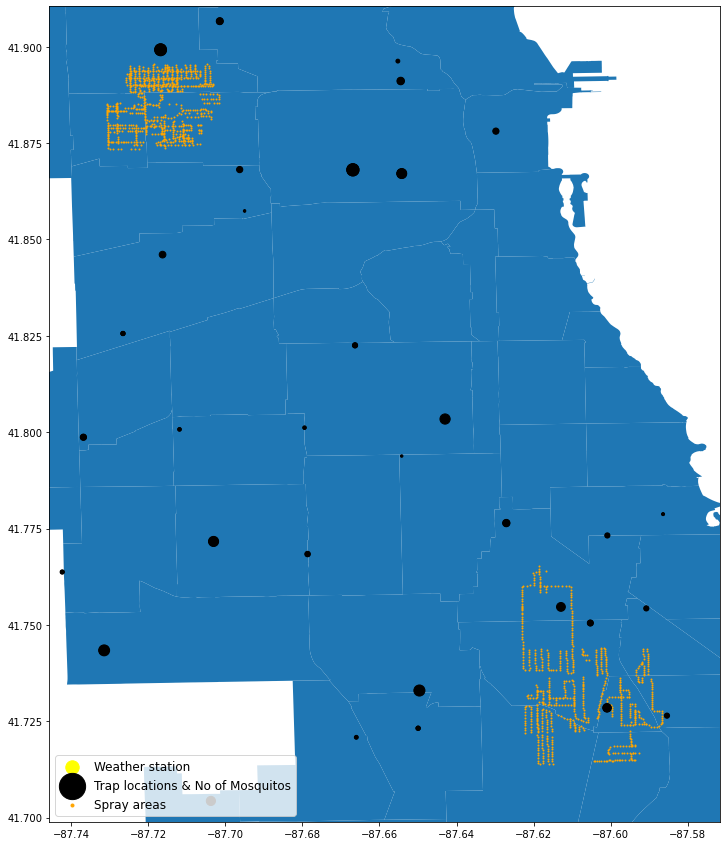

In [20]:
n=6
spray_date = pd.Timestamp(limit_table['Date'][n])

two_wks_before = {'Trap locations & No of Mosquitos':\
                  df_train[(df_train["Date"] >= spray_date - datetime.timedelta(weeks=2)) &\
                           (df_train["Date"] < spray_date)], 
                  'Spray areas': df_spray[(df_spray["Date"] == spray_date)]
                 }
   
print(f"Effect on number of mosquitos 2 weeks BEFORE {spray_date}")            
plot_spray(two_wks_before, spray_date)

# mosquito numbers two weeks after spray
two_wks_after = {'Trap locations & No of Mosquitos':\
                 df_train[(df_train["Date"] >= spray_date) &\
                          (df_train["Date"] < spray_date + datetime.timedelta(weeks=2))],
                 'Spray areas': df_spray[(df_spray["Date"] == spray_date)]
                }
print(f"Effect on number of mosquitos 2 weeks AFTER {spray_date}")
plot_spray(two_wks_after, spray_date)

## Spray effectiveness on 29 August 2013

Effect on number of mosquitos 2 weeks BEFORE 2013-08-29 00:00:00


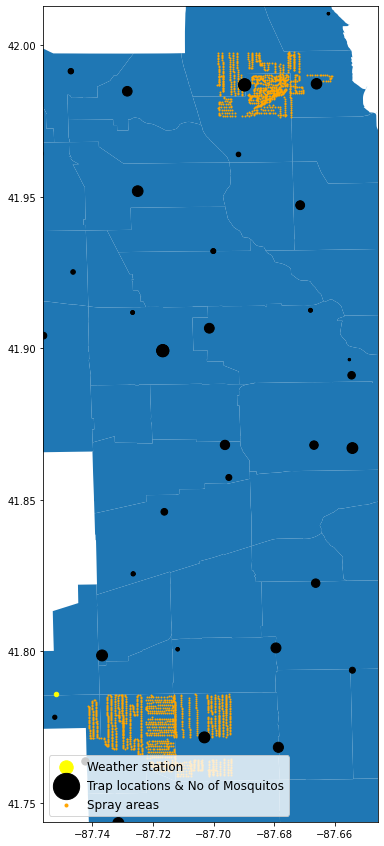

Effect on number of mosquitos 2 weeks AFTER 2013-08-29 00:00:00


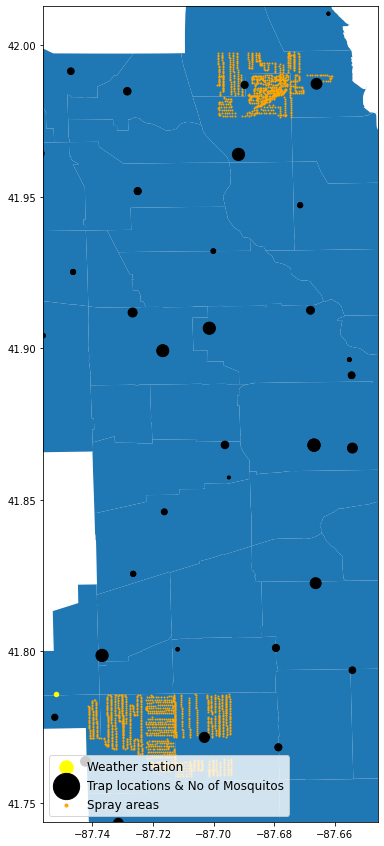

In [21]:
n=7
spray_date = pd.Timestamp(limit_table['Date'][n])

two_wks_before = {'Trap locations & No of Mosquitos':\
                  df_train[(df_train["Date"] >= spray_date - datetime.timedelta(weeks=2)) &\
                           (df_train["Date"] < spray_date)], 
                  'Spray areas': df_spray[(df_spray["Date"] == spray_date)]
                 }
   
print(f"Effect on number of mosquitos 2 weeks BEFORE {spray_date}")            
plot_spray(two_wks_before, spray_date)

# mosquito numbers two weeks after spray
two_wks_after = {'Trap locations & No of Mosquitos':\
                 df_train[(df_train["Date"] >= spray_date) &\
                          (df_train["Date"] < spray_date + datetime.timedelta(weeks=2))],
                 'Spray areas': df_spray[(df_spray["Date"] == spray_date)]
                }
print(f"Effect on number of mosquitos 2 weeks AFTER {spray_date}")
plot_spray(two_wks_after, spray_date)

## Spray effectiveness on 5 September 2013

Effect on number of mosquitos 2 weeks BEFORE 2013-09-05 00:00:00


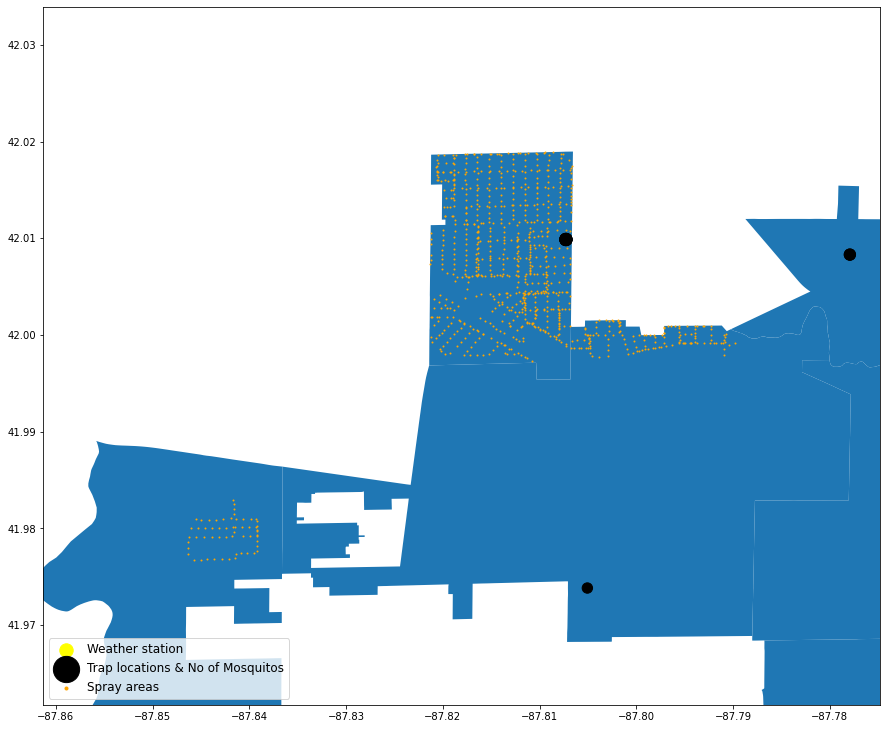

Effect on number of mosquitos 2 weeks AFTER 2013-09-05 00:00:00


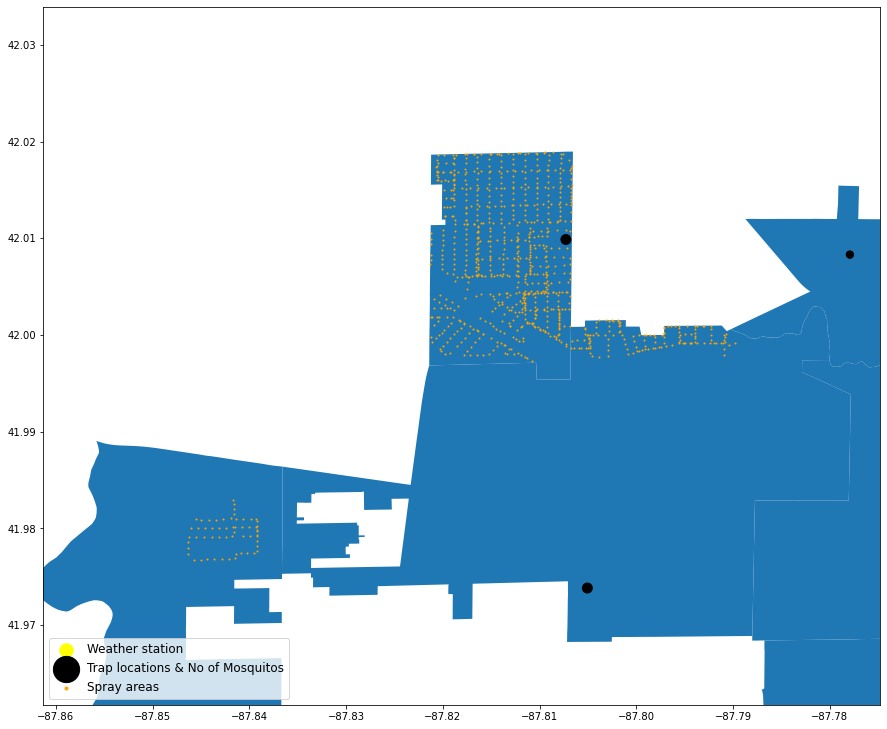

In [22]:
n=8
spray_date = pd.Timestamp(limit_table['Date'][n])

two_wks_before = {'Trap locations & No of Mosquitos':\
                  df_train[(df_train["Date"] >= spray_date - datetime.timedelta(weeks=2)) &\
                           (df_train["Date"] < spray_date)], 
                  'Spray areas': df_spray[(df_spray["Date"] == spray_date)]
                 }
   
print(f"Effect on number of mosquitos 2 weeks BEFORE {spray_date}")            
plot_spray(two_wks_before, spray_date)

# mosquito numbers two weeks after spray
two_wks_after = {'Trap locations & No of Mosquitos':\
                 df_train[(df_train["Date"] >= spray_date) &\
                          (df_train["Date"] < spray_date + datetime.timedelta(weeks=2))],
                 'Spray areas': df_spray[(df_spray["Date"] == spray_date)]
                }
print(f"Effect on number of mosquitos 2 weeks AFTER {spray_date}")
plot_spray(two_wks_after, spray_date)

# Recommendation
*Back to [Contents](#Contents:)*

# Conclusion
*Back to [Contents](#Contents:)*